In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, x_val_tensor, y_val_tensor

In [7]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0
    model.train()
    for x,y in dataloader:
        x,y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()

In [8]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        x,y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()
    return eval_loss, pred

In [9]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1,len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker='.')
    plt.plot(epochs, val_loss_list, label='val_err', marker='.')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
path = 'https://bit.ly/ds_boston_csv'
data = pd.read_csv(path)

target = 'medv'
x = data.drop(target, axis=1)
y = data.loc[:,target]

x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=.2, random_state=20)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

y_train = y_train.values
y_val = y_val.values

train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [14]:
n_feature = x.shape[1]
model2 = nn.Sequential(nn.Linear(n_feature,2),
    nn.ReLU(),
    nn.Linear(2,1),
).to(device)

Epoch 1, train loss: 617.0671, val loss: 538.862122
Epoch 2, train loss: 612.7968, val loss: 533.226074
Epoch 3, train loss: 603.3619, val loss: 527.647461
Epoch 4, train loss: 596.7290, val loss: 522.116211
Epoch 5, train loss: 594.6821, val loss: 516.620056
Epoch 6, train loss: 583.6642, val loss: 511.174561
Epoch 7, train loss: 579.7690, val loss: 505.835358
Epoch 8, train loss: 584.5288, val loss: 500.520538
Epoch 9, train loss: 569.1526, val loss: 495.195099
Epoch 10, train loss: 563.3892, val loss: 489.954590
Epoch 11, train loss: 555.1291, val loss: 484.768890
Epoch 12, train loss: 554.0765, val loss: 479.606567
Epoch 13, train loss: 543.6490, val loss: 474.468536
Epoch 14, train loss: 547.8553, val loss: 469.448944
Epoch 15, train loss: 544.3659, val loss: 464.465240
Epoch 16, train loss: 538.4074, val loss: 459.496338
Epoch 17, train loss: 529.3818, val loss: 454.508453
Epoch 18, train loss: 523.9531, val loss: 449.621521
Epoch 19, train loss: 523.0116, val loss: 444.814117
Ep

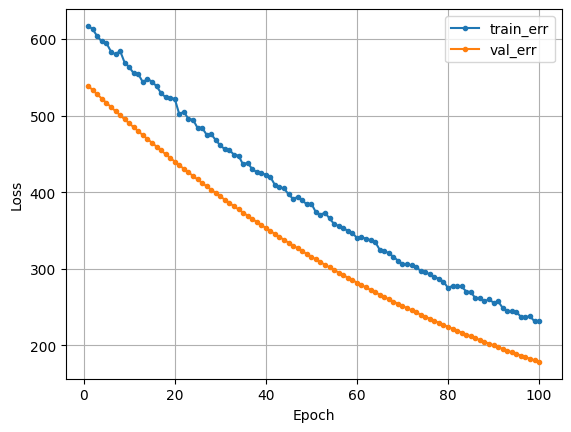

In [16]:
loss_fn = nn.MSELoss()
optimizer = Adam(model2.parameters(), lr=0.01)

epochs = 100
tr_loss_list, val_loss_list = [],[]
for t in range(epochs):
    tr_loss = train(train_loader, model2, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model2, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss: {tr_loss:.4f}, val loss: {val_loss:4f}')

dl_learning_curve(tr_loss_list, val_loss_list)